Level: Advanced

Topic type: unexplored and recently developed topics

# Outlook: Multi-modal Approaches

1. Introduction
2. TESSA
3. CoNGA
4. mvTCR
5. Questions
6. Take Aways

## 1. Introduction

With the development of novel single cell technology, IR sequencing is combined often with other Omic-layers, especially with transcriptomics (e.g. []). For B- and T-cells this enables the analysis of various characteristics on a single cell level: while the transcriptome provides insights into the current state of the cell, the IR is indicative for the cell's specificity and thereby explains the cell's fate upon infection or vaccination. 

While studies often provide paired measurements for both modalities, these are often analyzed individually utilizing only limited shared information. Often the IR sequence serves mainly as a barcode to the trajectory of cells over time [] or activation states []. The transcriptomic layer however is then used to identify the ... for clonotypes of intest. However, this underutilizes the additional information provided by paired data, since IRs and gene expression have been shown to be interlinked: adaptive immune cells recognizing the same epitopes, will undergo a similar development upon activation. Therefore, it has been shown that adaptive immune cells with identical? similar IR, expressed a similar phenotype.

Only recently, three methods were developed to jointly utilize TCR sequences and transcriptome each aiming at different aspects of analysis. Due to their novelty, these approaches have not been subjected to benchmark testing and a detailed external evaluation of their strength and weaknesses is therfore missing. The use of the following methods is therefor still marked as experimental for purpose of this tutorial. It may be noted that all methods were developed for TCRs in their original publication. However, due to the developmental similarity between B- and T-cells, the methods might also be applicable for B cells as well after carefull evaluation.

pip install tzlocal
pip install simplegeneric
conda install -c conda-forge r-igraph
conda install -c conda-forge r-data.table 

### 1.1 Data Preparation

In [1]:
import os

In [2]:
import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

C:\Users\felix.drost\Anaconda3\envs\best_practice\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\felix.drost\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path_data = 'data'

path_tmp = 'tmp'  # Folder for files needed for the differen approaches
path_res = 'res'  # Folder for results

for p in [path_tmp, path_res]:
    if not os.path.exists(p):
        os.makedirs(p)

First we will load the Gene expression data processed and provided by the authors:

In [4]:
path_gex = f'{path_data}/E-MTAB-10026.processed.4/covid_portal_210320_with_raw.h5ad'
adata = sc.read(path_gex)

We will load the already preprocessed data provided by the authors using scanpy for data handling.

In [5]:
path_tcr = f'{path_data}/TCR_01_preprocessed_tcr.h5ad'
adata_tcr = sc.read(path_tcr)

We will combine both modalities to a shared data object, which will store IR information in adata.obs and GEX in adata.X.

In [6]:
ir.pp.merge_with_ir(adata, adata_tcr)

This dataset contains data from various immune cell types. All algorithms require paire IR-GEX data, so we will select all T-cells. We do this, be keeping only cells, where the cell type annotation is a T-cell subtype. Since the following models rely on paired GEX-VDJ data we will filter cells without full immune receptor.

In [7]:
tags_tcells = ['CD8', 'CD4', 'Treg', 'MAIT',]
adata = adata[adata.obs['initial_clustering_x'].isin(tags_tcells)]

In [8]:
adata = adata[~adata.obs['IR_VDJ_1_junction_aa'].isna()]
adata = adata[~adata.obs['IR_VJ_1_junction_aa'].isna()]

To speed up the methods below, we will only use the data from the most represented patient.

In [9]:
adata = adata[adata.obs['patient_id_x'] == 'AP6']
print('Amount of cells: ', len(adata))

Amount of cells:  4350


To get an overview, we will plot the data with cluster assigment as a UMAP visualisation.

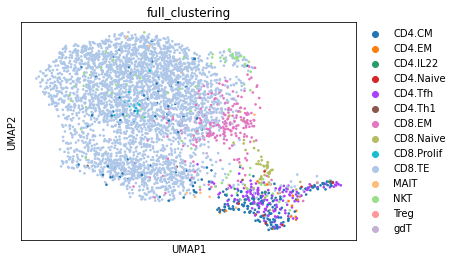

In [147]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='full_clustering')

## 2. TESSA
... et al developed TCR functionallandscape estimation supervised with scRNA-seq analysis (TESSA), which aims at embedding and clustering T cell clones based on their TCR sequence and transcriptome via Bayesian modelling. The CDR3beta sequence is first compressed to a 30-dimensional numeric representation using a (pretrained?, Variational?) Autoencoder. Following, the dimensions are upweighted to correlate the TCR representation with the gene expression of similar TCR-groups, thereby assigning importance of TCR position? for explaining the cells gene expression. In an interative process, weights and groups are updated until convergence to reach a maximal allignment between both modalities.

TESSA produced clusters of high purity when embedding Tcells with known epitope specificity from [10x], surpasing the uni-modal model GLIPH [], which is commonly used for clustering TCR sequences. Further, cluster centrally was indicative for higher avidity clones shown by clonal expansion and high ADT counts. Using TESSA on data from [Yost], the author detected novel clusters of responder T cell in patients undergoing PD-1 blockade. 

### 2.1 Setup TESSA
This explanation is based on the TESSA Github repository (https://github.com/jcao89757/TESSA) and might eventually change with new versions of the tool. Since the tool requires specific pyhton and R packages, we will create a new Conda environmnet which will capture both. Please be aware, that depending on your system, you might need to do small changes during environment setup.

conda create --name TESSA
conda activate TESSA
conda install python==3.6.4
conda install -c conda-forge r-base==3.5.1

conda install -c conda-forge numpy==1.19.5
conda install -c conda-forge pandas==0.23.4
conda install h5py==2.10.0
conda install -c conda-forge tensorflow==1.11.0
pip install keras==2.2.4

conda install -c r r-mass
conda install -c conda-forge r-rtsne

R
install.packages('LaplacesDemon')

#conda install h5py==2.10.0

### 2.1 Data Preperation
TESSA requires several TCR and GEX files in specific format.

First, we save a ".csv"-File with the the following columns:
- "contig_id": cell barcodes as index column
- "cdr3": CDR3beta amino acid sequence trimmed for starting C and ending F



In [49]:
df_tcr = adata.obs
df_tcr.index.name = 'contig_id'
df_tcr['cdr3'] = [seq[1:-1] for seq in df_tcr['IR_VDJ_1_junction_aa']]  # trimm cdr3 sequence

df_tcr = df_tcr[['cdr3']]  # select only columns needed

df_tcr.to_csv(f'{path_tmp}/TESSA_tcrs.csv')
df_tcr.head(5)

,cdr3
contig_id,
S11_AAACCTGGTAATTGGA-1,ASSPGTGTYGYT
S11_AAACCTGGTAGCACGA-1,ASSIPGAVHEQY
S11_AAACCTGTCGCCGTGA-1,ASSPQTGVARYGYT
S11_AAACCTGTCTTATCTG-1,ASLGNTEAF
S11_AAACGGGGTAGCGATG-1,ASSGGGSSYNEQF


We will now filter the 10% most variable genes, as done in the TESSA publication.

In [11]:
n_genes = adata.shape[1] // 10
sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)
adata_tessa = adata[:, adata.var['highly_variable']].copy()

We now store the GEX matrix to a ".csv"-File. TESSA requires the transposed matrix of the adata object. I.e. the rows represent the different genes and the columns indicate a specific cell. For this, we will store the count data in a DataFrame with the right index and column names. Following, we transpose the DataFrame.

In [12]:
count_mat = adata_tessa.X.A
df_counts = pd.DataFrame(count_mat)

df_counts.index = adata_tessa.obs.index
df_counts.index.name = ''
df_counts.columns = adata_tessa.var.index

df_counts = df_counts.transpose()

df_counts.to_csv(f'{path_tmp}/TESSA_gex.csv')
df_counts.head()

,S11_AAACCTGGTAATTGGA-1,S11_AAACCTGGTAGCACGA-1,S11_AAACCTGTCGCCGTGA-1,S11_AAACCTGTCTTATCTG-1,S11_AAACGGGGTAGCGATG-1,S11_AAACGGGGTCGGCACT-1,S11_AAACGGGGTTACGGAG-1,S11_AAAGCAAAGAGCAATT-1,S11_AAAGCAAAGCAGGTCA-1,S11_AAAGCAAAGGCAGGTT-1,...,S12_TTTGGTTGTACATCCA-1,S12_TTTGGTTGTAGGACAC-1,S12_TTTGGTTTCAAGAAGT-1,S12_TTTGGTTTCTACTATC-1,S12_TTTGGTTTCTCGCTTG-1,S12_TTTGTCACACGGTAGA-1,S12_TTTGTCAGTAGAAAGG-1,S12_TTTGTCAGTGAGTGAC-1,S12_TTTGTCATCCACTCCA-1,S12_TTTGTCATCGCATGAT-1
HES4,0.0,0.00000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
ISG15,0.0,1.54457,2.430966,0.9284,0.0,1.64661,1.565189,4.062155,1.53851,2.475721,...,1.884326,1.988038,0.0,1.581859,1.511785,0.0,2.015501,2.088418,1.611682,0.0
TTLL10,0.0,0.00000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
TNFRSF18,0.0,0.00000,0.000000,0.0000,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
TNFRSF4,0.0,0.00000,0.000000,0.9284,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


## 2.2 Running the model
To run the model, we will need to provide different setting options, most of which specify input or output directories. We will summarize them in a dictionary first.

In [22]:
settings_full = {
    # Input files
    'tcr': f'{path_tmp}/TESSA_tcrs.csv',
    'exp': f'{path_tmp}/TESSA_gex.csv',
    
    # TESSA models
    'model': f'TESSA/BriseisEncoder/TrainedEncoder.h5',
    'embeding_vectors': f'TESSA/BriseisEncoder/Atchley_factors.csv',
    
    # Output files
    'output_TCR': f'{path_res}/TESSA_tcr_embedding.csv',
    'output_log': f'{path_res}/TESSA_log.log',
    'output_tessa': f'{path_res}',
    'within_sample_networks': 'FALSE',
}

In the next step, we will create the command for running TESSA by adding setting key and setting option.

In [26]:
command_full = 'conda activate TESSA && '

command_full += 'python TESSA/Tessa_main.py'
for key, value in settings_full.items():
    command_full += f' -{key} {value}'
command_full

'conda activate TESSA && python TESSA/Tessa_main.py -tcr tmp/TESSA_tcrs.csv -exp tmp/TESSA_gex.csv -model TESSA/BriseisEncoder/TrainedEncoder.h5 -embeding_vectors TESSA/BriseisEncoder/Atchley_factors.csv -output_TCR res/TESSA_tcr_embedding.csv -output_log res/TESSA_log.log -output_tessa res -within_sample_networks FALSE'

Finally, we run the model on the specified settings by calling the command. Depending on your computer this might take several minutes.

In [27]:
!$command_full

2022-04-20 15:12:02.778163: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
Using TensorFlow backend.
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 


Initialization
[1] 123

Iteration round: 1 
  # clusters: 679 
  Clustering rate: 0 
  Recent b acceptance rate: 0 

Iteration round: 2 
  # clusters: 163 
  Clustering rate: 0.918 
  Recent b acceptance rate: 0 

Iteration round: 3 
  # clusters: 117 
  Clustering rate: 0.997 
  Recent b acceptance rate: 0 

Iteration round: 4 
  # clusters: 116 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 5 
  # clusters: 117 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 6 
  # clusters: 118 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 7 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 8 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 9 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 10 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 11 
  # clu

C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint16 = np.dtype([("quint16", np.uint16, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint32 = np.dtype([("qint32", np.int32, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:532: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  np_resource = np.dtype([("resource", np.ubyte, 1)])
sys:1: FutureWarning: arrays to stack must be 


Iteration round: 24 
  # clusters: 118 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 25 
  # clusters: 118 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 26 
  # clusters: 119 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 27 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 28 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 29 
  # clusters: 120 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 30 
  # clusters: 120 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 31 
  # clusters: 120 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 32 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 33 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 34 
  # clusters: 119 
  C

Iteration round: 600 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 601 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 602 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 603 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 604 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 605 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 606 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 607 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 608 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 609 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 610 
  # clusters

## 2.3. Output
We now recieve two output files, that we can further use for downstream tasks:
- TESSA_tcr_embedding.csv: Embedding of TCRs (without GEX information)
- result_meta.csv: cluster assignment by cell
- tessa_final.RData: Containing inferred model parameters (e.g. weightening vector b)

To analyse the TESSA output, load the TCR embedding. We will create an adata object for easier data handling:

In [109]:
tessa_embedding = pd.read_csv(f'{path_res}/TESSA_tcr_embedding.csv', index_col=0)
tessa_embedding = sc.AnnData(X=tessa_embedding.values, obs=adata.obs)

We can now apply various analysis steps on this embedding such as visualization. Let's plot a TSNE plot colored by celltype.

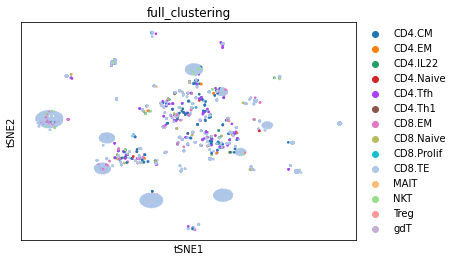

In [152]:
sc.pp.neighbors(tessa_embedding)
sc.tl.tsne(tessa_embedding)
sc.pl.tsne(tessa_embedding, color='full_clustering')

As a next step, we will load the cluster assignments created by TESSA saved in 'result_meta.csv' and add it to the adata object. Each cluster is named after one clonotype CDR3beta region within this cluster 

In [156]:
clustering = pd.read_csv(f'{path_res}/result_meta.csv', index_col=0)
tessa_embedding.obs['TESSA_cluster'] = clustering['cluster_number'].values
print('Unique clusters:', tessa_embedding.obs['TESSA_cluster'].nunique())

Unique clusters: 125


There are 125 unique clusters. For visualization, we will plot only the 10 most abundent clusters within the adata object to a TSNE plot.

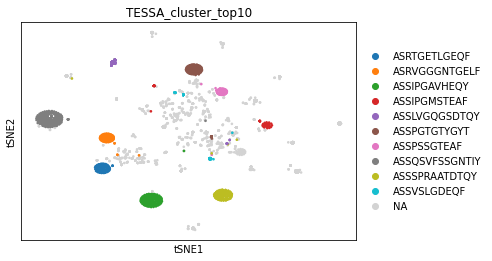

In [153]:
top_10_clusters = tessa_embedding.obs['TESSA_cluster'].value_counts().head(10).index
tessa_embedding.obs['TESSA_cluster_top10'] = tessa_embedding.obs['TESSA_cluster'].apply(
                                                lambda x: x if x in top_10_clusters else np.nan)

sc.pl.tsne(tessa_embedding, color='TESSA_cluster_top10')

For plotting the cluster assignemnt in the GEX space, we add the assignment to the original adata object. When plotting, we can see that TESSA clusters also share similar phenotypes at GEX level.

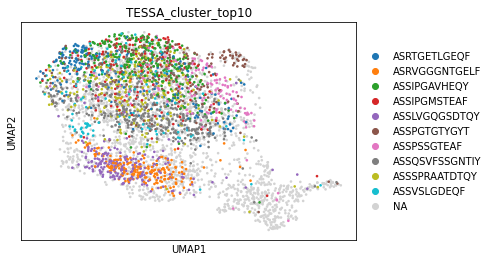

In [149]:
adata.obs['TESSA_cluster_top10'] = tessa_embedding.obs['TESSA_cluster_top10']
sc.pl.umap(adata, color='TESSA_cluster_top10')

TESSA offers additional visualization of clonotype networks. To access this, we will use the provided R scripts.

We first need to set the path to our R environment, you might need to adjust the path, based on the location of your python environment before importing the rpy2 interface between python and R.

In [37]:
# Create path to standard Anaconda location
home = os.path.expanduser('~')
os.environ['R_HOME'] = f'{home}/Anaconda3/envs/best_practice/Lib/R'
os.environ['R_LIBS'] = f'{home}/Anaconda3/envs/best_practice/Lib/R/lib'

import rpy2.robjects as rob
%load_ext rpy2.ipython

We use jupyter notebooks linemagic to load the TESSA results and visualization code. Following, we call the two visualization functions. They will output PDF plots to the results directory.

In [49]:
%%R -i path_res
load('res/tessa_final.RData')
source('TESSA/Tessa/post_analysis.R')
plot_Tessa_clusters(tessa_results, path_res)
plot_tessa(tessa_results, path_res)

This plot provides us with a visulisation of the clonotype netwoorks. The dot size here represents the clonal expansion of the individual clone.

In [55]:
from IPython.display import IFrame
IFrame("res/TCR_explore_clusters.pdf", width=600, height=300)

There are several other plots, that can be found in the output folder. As an example, here you can see the dependency between TCR distance and GEX distance within each clonotype cluster.

In [52]:
IFrame("res/exp_TCR_pair_plot.pdf", width=600, height=300)

## 3. CoNGA
clonotype neighbor graph analysis (CoNGA) uses similarity graphs at a clonotype level on GEX and TCR, for which the well known distance metric TCRDist [] is used. Based on the graph neighborhood, clusters are formed by shared GEX and TCR assignments. These so called "CoNGA clusters" thereby share similar receptor sequences as well as similar gene expression. 

CoNGA clusters contained clonotypes with highly alike TCRs based on e.g. length and physio-chemical properties and were shown to capture specificity well on []. Among other things, CoNGA was used to identified clusters of mhc-indepent HOBIT/HELIOS-type T-cells in data from []. 

Note, that CoNGA offers support to BCR sequences as stated on their GitHub Page. However, this was not part of the evaluation in the original publication.

In [50]:
adata.X.max()

6.920321

## 4. mvTCR
mvTCR by An et al is a multiview Variational Autoencoder that compresses TCR sequence and gene expression into a lower-dimensional representation []. Two deep learning archtictures - Transformer and Multi-layer perceptron - extract information from both TCR and GEX respectively, before they are fused to derive the joint space. Following, the trained models can be used to embedd similar data. 

The authors showed, that multi-modal models can better capture antigen specificity, than uni-modal embeddings on the data from [] for prediction and clustering. Additionally, they showed that cell type and cell functionality are preserved in the embedding space on a SARS-CoV-2 dataset from [].

### 4.1 Installation
Installation is explained at https://github.com/SchubertLab/mvTCR.
We will clone the git repository and install the requierements from file.

In [ ]:
! git clone https://github.com/SchubertLab/mvTCR.git

In [ ]:
! conda activate best_practice && pip install -r mvTCR/requirement.txt

Additional, you will need to install pyTorch 1.8.0. Depending on your OS type, you can find the correct pip or conda command here: https://pytorch.org/get-started/previous-versions/

### 4.2 Preparing the data
mvTCR relies on the scanpy data format anndata. For training the model, we need to prepare our adata object. For that, the several functions are provided.

In [15]:
import comet_ml  # needs to be imported as a first step

import sys
sys.path.append('mvTCR')
sys.path.append('.')

import tcr_embedding.utils_training as utils
from tcr_embedding.models.model_selection import run_model_selection
from tcr_embedding.utils_preprocessing import group_shuffle_split, encode_tcr

The adata object requires a clonotype assignement (see notebook X). Since mvTCR uses both chains of the primary receptor, we will use this information for defining the clonotype as well.

In [11]:
ir.tl.define_clonotypes(adata, key_added='clonotype', receptor_arms='all', dual_ir='primary_only')

100%|███████████████████████████████████████████████████████████████████████████████| 723/723 [00:00<00:00, 887.54it/s]


The model requires a numeric encoding of the CDR3alpha and CDR3beta chain. For that, we need to provide the columns containing the amino acid sequences. Additional, the pad attribute indicates the maximal length of the sequence. If we do not want to embedd aditional data afterwards, we can set it to the maximal sequence length.

In [12]:
pad = max(adata.obs['IR_VJ_1_junction_aa'].str.len().max(), adata.obs['IR_VDJ_1_junction_aa'].str.len().max())
encode_tcr(adata, column_cdr3a='IR_VJ_1_junction_aa', column_cdr3b='IR_VDJ_1_junction_aa', pad=pad)

The data needs to be divided into a training and validation data. This is done by setting the values 'train' or 'val' for each cell in adata.obs['set']. By choosing the 'clonotype' and 0.2, the dataset used to evaluate the models performance will contain approximately 20% of unique clonotypes to the training set. This setting can generally be used for data analysis.

In [13]:
train, val = group_shuffle_split(adata, group_col='clonotype', val_split=0.2)
adata.obs['set'] = 'train'
adata.obs.loc[val.obs.index, 'set'] = 'val'

### 4.3 Training the model

We need to provide various information, that are used during training:

In [18]:
params_experiment = {
    'study_name': 'test_haniffa',  # Name that identifies the study
    'comet_workspace': None,  # if logging is not performed via Comet-ml, this should be None
    'model_name': 'moe',  # Type of mixture model used during training, authors suggest using Mixture of Export (moe)
    'balanced_sampling': 'clonotype',  # Column containing the id for clonotypes
    'save_path': path_res  # Output path, were the selected models are stored 
}

mvTCR runs a hyperparameter optimization to choose the best model architecture. For general analysis, the optimization mode 'pseudo_metric' is most suited. Here, the best model is determined by the capability of preserving multiple characteristics of the dataset. In the following, we choose identical TCR sequence ('clonotype') and cell type ('functional.cluster') both equally weighted (1 and 1). If after training the model, the latent space is dominated by one modality, we can rerun the model with different weightings.

In [21]:
params_optimization = {
    'name': 'pseudo_metric',
    'prediction_labels':
        {'clonotype': 1,
         'full_clustering': 1}
}

Finally, we can run the model selection. Especially for larger datasets an extensive model search was used by the authors. As a showcase, we here only train 3 models. We recommend using a computer with GPU, eventhen the model will train several minutes.

In [ ]:
n_runs = 3
run_model_selection(adata, params_experiment, params_optimization, n_runs)

[I 2022-04-21 16:11:00,869] A new study created in RDB with name: test_haniffa
  4%|███▌                                                                            | 9/200 [03:28<1:11:01, 22.31s/it]

### 4.4 Output
We now have a trained model, that we can use to embedd data to a represention capturing TCR and GEX, simultaneaously.

For this, we will load the best model from our studies folder.

In [18]:
best_trial = 0
path_model = f'../res/trial_{best_trial}/best_model_by_metric.pt'
model = utils.load_model(adata, path_model)

In a next step, we can now embedd this data and assign the annotation to our new embedded adata object.

In [19]:
mvtcr_embedding = model.get_latent(adata, metadata=[])
mvtcr_embedding.obs = adata.obs.copy()

This embedding can now be used for data analysis such as visualization. For this we will select the top 10 most abundant clonotypes within the sample.

In [150]:
top_10_clones = mvtcr_embedding.obs['clonotype'].value_counts().head(10).index
mvtcr_embedding.obs['clonotypes_top10'] = mvtcr_embedding.obs['clonotype'].apply(
                                                lambda x: x if x in top_10_clones else np.nan)

Now, we will be using UMAPs to show cell type assignment and the top 10 clonotypes.

In [157]:
sc.pp.neighbors(mvtcr_embedding)
sc.tl.umap(mvtcr_embedding)
sc.pl.umap(mvtcr_embedding, color=['full_clustering', 'clonotypes_top10'], ncols=1)

NameError: name 'mvtcr_embedding' is not defined

## 5. Questions

Why could it be useful to integrate IR-sequence information with gene expression?
- GEX can be used to improve IR sequence reads.
+ Both modalities provide different insights into the cell, while still being interdependent.
- Since both modalities capture the same information, integrating them provides an additional quality check.
- For most cells either GEX or IR is measured. Integrating thereby allows analysis of all cells.

What information provides us the IR sequence, that is not directly captured in GEX?
- A count matrix between cell and antibody-tagged epitope bindings.
- The IR sequence can be used for demultiplexing between different donors.
+ The cell's clonotype and thereby cell ancestory is defined by the IR sequence.
+ The IR sequence determines specificity and is therefor a barcode for recognizing the same epitope.

On what premise rely the approaches above?
+ Cells of same or alike IRs often have a similar phenotype.
- Information of IR and GEX provide orthogonal information to each other, since they are independent.
- Knowledge is transfered between large gene expression datasets into which IR data can be mapped.
- Each cell occurs clonally expanded and thereby provides multiple gene profiles.

## 6. Take Aways

- Cell functionality (determined by IR) and cell state (observed via GEX) are interlinked. Cells with alike IR sequences share the similar phenotypes [].
- Due to the inherent structural difference between count matrixs (GEX) and amino acid sequences (IR), it is difficult to directly fuse both modalities.
- Several methods were developed to utilize paired GEX-IR data relying on different approaches such as Bayesian Models [], Graph Theory [], and Deep Learning [].
- Due to the novelty of all methods and the lack of standardarized evaluation, these are not independently benchmarked yet and are hard to compare. 
- All methods were developed for TCRs. While they can in theory easily be applied on BCR data and partially offer a BCR interface (CoGNA), this was not part of the original publication and is not evaluated yet.